# Assignment
The basic problem is the emergence of an unknown infectious disease. There is 1 person infectious and a population of 100000 is susceptible. The character of the disease is unknown up front. The challenge is to design a strategy to prevent a disruptive outbreak, while the invasiveness of the strategy should be kept proportional to the severity of the disease. That is, there is no reason to quarantine everyone and close schools etc. if there is no evidence that the disease is really serious. 

The following table specifies the uncertainties surrounding the outbreak. They have been informed by experience with previous outbreaks of a wide range of diseases. 

|Uncertainties              |Range	        |Default value|
|--------------------------:|--------------:|------------:|
|Average incubation time   	|0.5 – 14	    |2            |
|Average infectious period	|7 – 21      	|14           |
|Basic reproduction number 	|0.5 – 5	    |2            |
|Case fatality rate	        |0.01 – 0.5	    |0.01         |
|Switch SEIR or SIR     	|{1, 0}	        |0            |

The following initial values should be used

|Constants                       | Value |
|-------------------------------:|------:|
|Initial deceased population     |0      |
|Initial exposed population      |0      |
|Initial infectious population   |1      |
|Initial recovered population    |0      |
|Initial susceptible population  |100000 |

The model is provided as a vensim mdl file (EIR or SIR 20170501.mdl), but is importable using pysd. That is, you should be able to work with the model also on a mac and with Python 64 bit. Any interventions can be added to the model through vensim before importing the modified model into pysd. For those of you who don't have pysd installed, it is available through pip. 

A starting point for inspiration for the assignment is the work of Willem Auping, Erik Pruyt and me on the Mexican Flu and Ebola. A quick search in Scopus should point you to the relevant papers. To get a sense for how decision making takes place during massive pandemics, a further literature search on either the most recent ebola outbreak or the Mexican flu should turn up relevant papers. 


## Key requirements of the assignment
* Any modeled interventions should have a clear real world meaning, and the link between the model and the real world interpretation should be given.
* The design of any candidate intervention should be clearly motivated
* Not all relevant decision considerations can be covered by the model, a proper balance between modeling and qualitative reasoning is thus required. For example, the default model only covers the dynamics of a disease, and not the disruptive impact of quarantines and social distancing polices (e.g. closing schools).

## Key Deliverables
* a final report with a motivated strategy for counteracting the disease
* a reflection on the advice given the political context of time urgent high risk decision making as typically encountered during pandemic outbreaks. Provide a strategy to ensure that the advice has impact and discuss three potential risks associated with it, related to the political dynamics often present here.
* a collection of reproducible model based analyses that were conducted while crafting the strategy. Here reproducible means that anyone of your fellow students should be able to rerun your analyses. This entails clear explicit documentation of your code, clearly state any non-standard dependencies, and ensure that all the relevant files etc. are submitted in a clear directory structure. In addition, there should be an explicit motivation for each analysis step. This motivation should involve references to relevant literature where appropriate (see also http://nbviewer.jupyter.org/github/ipython/nbconvert-examples/blob/master/citations/Tutorial.ipynb for one way of doing this in notebooks). 

Time permitting, I plan to do a friendly bake-off where I will compare the performance of all strategies from all groups over a set of scenarios. There might be some black swans amongst the scenarios.... . This bake-off will result in a many-objective robustness ranking of all strategies. To make this work, it is paramount that I receive from each group a vensim / pysd model with the final advised strategy, and the associated python code for running the model. 

## Grading considerations
* appropriate and correct use of various exploratory modeling techniques
* quality of interpretation of exploratory modeling results
* clarity of reasoning in translating interpretation of exploratory modeling results into candidate interventions
* use of additional literature beyond course readings
* the correctness of translating a strategy into the System Dynamics model. Given that System Dynamics is not the focus of this core, this criterion will not be weighted to heavily. 




# Now it begins

Model running and saving scripts are hashtagged because of the capacity of the computer. Results are directly read from saved files

In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import pandas as pd
# import statsmodels.api as sm
import SALib
import seaborn as sns
import mpl_toolkits.axisartist as AA
import mpld3
import scipy as sp
import copy
import matplotlib.ticker as ticker

from ema_workbench import (Model, RealParameter, IntegerParameter, Policy, CategoricalParameter, Constant, TimeSeriesOutcome, ScalarOutcome, perform_experiments, ema_logging, save_results, load_results)
from ema_workbench.em_framework.evaluators import LHS, SOBOL, MORRIS, SequentialEvaluator
from ema_workbench.connectors.pysd_connector import PysdModel 
from ema_workbench.connectors.vensim import VensimModel
from ema_workbench.em_framework.samplers import sample_levers, sample_uncertainties
from ema_workbench.em_framework.salib_samplers import get_SALib_problem
from ema_workbench.util import load_results
from ema_workbench.util import ema_logging

from ema_workbench.analysis import prim
from ema_workbench.analysis.plotting import lines
from ema_workbench.analysis.plotting_util import KDE
from ema_workbench.analysis.plotting_util import determine_time_dimension
from ema_workbench.analysis.pairs_plotting import pairs_scatter

from SALib.sample import saltelli
from SALib.analyze import sobol, morris
from SALib.test_functions import Ishigami

from mpl_toolkits.axes_grid1 import host_subplot

from scipy.stats import linregress

ema_logging.log_to_stderr(ema_logging.INFO)

C:\Users\guri_\Anaconda3\lib\site-packages\ema_workbench\connectors\__init__.py:18: ImportWarning: netlogo connector not available
  warnings.warn("netlogo connector not available", ImportWarning)


<Logger EMA (DEBUG)>

# 1. Base Model

## 1.1 Base Model Open Exploration

In [2]:
#Import Model into the notebook from local drive
bmodel = VensimModel("BaseModel", model_file=r'model/SEIR or SIR 20170501_BaseModel.vpm')

In [3]:
# Specify uncertainties and outcomes for base model
bmodel.uncertainties = [RealParameter('Average incubation time', 0.5, 14),
                        RealParameter('Average infectious period', 7, 21),
                        RealParameter('Basic reproduction number', 0.5, 5),
                        RealParameter('Case fatality rate', 0.01, 0.5),
                        IntegerParameter('Switch SEIR or SIR', 0, 2)
                       ]

bmodel.outcomes = [TimeSeriesOutcome('Susceptible population'),
                   TimeSeriesOutcome('Exposed population'),
                   TimeSeriesOutcome('Infectious population'),
                   TimeSeriesOutcome('Recovered population'),
                   TimeSeriesOutcome('Deceased population')
                  ]

In [14]:
# Run base model using Latin Hypercube Sampling for 1000 scenarios
# results_b = perform_experiments(bmodel, scenarios= 1000, uncertainty_sampling='lhs')

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [15]:
#Save Results
# save_results(results_b, 'results/results_base_lhs.tar.gz')

[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\results\results_b.tar.gz


In [ ]:
results_b = load_results('results/results_base_lhs.tar.gz')

In [6]:
# Define experiments and outcomes
experiments_b, outcomes_b = results_b

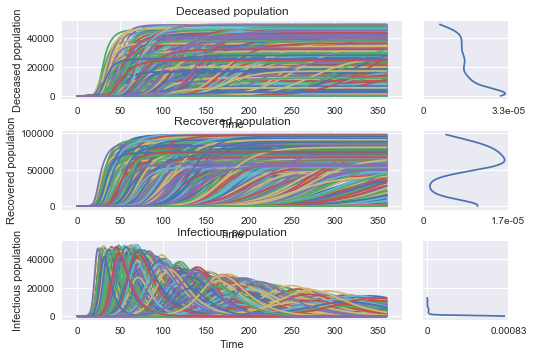

In [7]:
#Plot Results
lines(results_b, outcomes_to_show=['Deceased population', 'Recovered population', 'Infectious population', ], density= KDE)
plt.show()

## 1.2 Vulnerability Analysis for Base Model (first iteration)
At this section, first step of scenario discovery for the base model (as provided for the assignment) will be done. This step, altogether with Sensitivity Analysis and Open Exploration, is intended to provide initial insights regarding important uncertainties and behavior of the SIR-SEIR model.

At this phase, we would take deceased population as objective. Deceased population is also what we will take as main objective later on, as motivated separately in the report, since we are dealing with super infectious disease outbreak. Additionally, to gather more perspective, we would compare the open exploration result of deceased population and infectious population. Mean values of the end state of the objectives will be taken as basis for determining threshold, because it is important to see the average across all the experiments. This is also plotted in boxplots for visualization.

### 1.2.1 Sensativity Analysis for Base Model

In [6]:
# Run and save base model using Morris sampling for 500 times considering the capacity of RAM
# results_b_mo = perform_experiments(bmodel, 500, uncertainty_sampling=MORRIS)
# save_results(results_b_mo, 'results/results_base_morris.tar.gz')

[MainProcess/INFO] performing 3000 scenarios * 1 policies * 1 model(s) = 3000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2100 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 2700 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\results\results_b_mo.tar.gz


In [5]:
# Run and save base model using Sobol sampling for 500 time
# results_b_so = perform_experiments(bmodel, 500, uncertainty_sampling=SOBOL)
# save_results(results_b_so, 'results/results_base_sobol.tar.gz')

[MainProcess/INFO] performing 6000 scenarios * 1 policies * 1 model(s) = 6000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2400 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3600 cases completed
[MainProcess/INFO] 4200 cases completed
[MainProcess/INFO] 4800 cases completed
[MainProcess/INFO] 5400 cases completed
[MainProcess/INFO] 6000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\results\results_b_so.tar.gz


### linear regression

In [16]:
# Considering the capacity of RAM, it is better to load the saved results
results_b = load_results('results/results_base_lhs.tar.gz')
experiments, outcomes = results_b

In [17]:
# Convert results from array and dictionary to pandas dataframe
exp = pd.DataFrame(experiments)
out = pd.DataFrame(outcomes['Deceased population'])
# get a list of uncertainties
all_para = list(exp.columns)[:-3]

In [21]:
# Y is the dataframe at 360 simulation timestep, which is the ending point
Y = out[360]
X = exp[all_para]

# Conduct linear regression
X = sm.add_constant(X)
est = sm.OLS(Y, X).fit()
print(est.summary())

                            OLS Regression Results                            
Dep. Variable:                    360   R-squared:                       0.744
Model:                            OLS   Adj. R-squared:                  0.743
Method:                 Least Squares   F-statistic:                     577.8
Date:                Thu, 29 Jun 2017   Prob (F-statistic):          4.21e-291
Time:                        12:36:23   Log-Likelihood:                -10391.
No. Observations:                1000   AIC:                         2.079e+04
Df Residuals:                     994   BIC:                         2.082e+04
Df Model:                           5                                         
Covariance Type:            nonrobust                                         
                                coef    std err          t      P>|t|      [95.0% Conf. Int.]
---------------------------------------------------------------------------------------------
const                 

Deceased population is chosen as a key KPI. Although the base model is not linear, the R-square result suggests that linear regression can be refered in sensativity analysis. Abusolute values of Coeeficiences represent sensativity<br />
Coef ranking:<br />
___Case fatality rate > Basic reproducation number > Switch SEIR or SIR___<br />
However, Linear regression doesn't give satisfying R square in the following models. Therefore it is only used here for once.

### Morris

In [6]:
# load morris base model results
results_b_mo = load_results('results/results_base_morris.tar.gz')
experiments_mo, outcomes_mo = results_b_mo

In [10]:
# Convert experiments and outcomes to dataframe
exp_mo = pd.DataFrame(experiments_mo)
out_mo = pd.DataFrame(outcomes_mo['Deceased population'])
# Drop unnecessary columns in exp datafram
expdrop_mo=exp_mo.drop(['scenario_id','policy','model'],axis=1)
# Convert dataframe to matrix which is the format for SALib arguments
X_mo=expdrop_mo.as_matrix(columns=None)
# Convert dataframe to list and to array
Y_mo = list(out_mo[360])
Y_mo = np.asarray(Y_mo)

In [12]:
# define problem for SALib arguments using get_SALib_problem
problem = get_SALib_problem(bmodel.uncertainties)
# Morris sensativity analysis for base model
Si = SALib.analyze.morris.analyze(problem, X_mo, Y_mo, conf_level=0.95,num_levels=10, grid_jump=5, print_to_console=True)

Parameter                         Mu_Star         Mu    Mu_Star_Conf      Sigma
Average incubation time           922.010   -922.006         413.519   4748.939
Average infectious period        2402.956  -2402.954         684.831   7767.048
Basic reproduction number       26147.883  26147.883        2486.423  27993.808
Case fatality rate              35636.038  35636.038        1801.502  20244.416
Switch SEIR or SIR               1664.091  -1664.080         578.884   6867.752


Relative values of Mu_star are usually a good approximation of Sobol ST<br\>
Mu_star ranking:<br\>
___Case fatality rate > Basic reproduction number___<br\>
Morris is not as good as Sobol in terms of accuracy. Therefore, only Sobol will be used for all models.

### Sobol

In [4]:
# load Sobol base model results
results_b_so = load_results('results/results_base_sobol.tar.gz')
experiments_so, outcomes_so = results_b_so

[MainProcess/INFO] results loaded succesfully from D:\Python\epa1361_open-master\final assignment\results\results_b_so.tar.gz


In [5]:
# The same as I did for Morris, trim the experiments and outcomes
exp_so = pd.DataFrame(experiments_so)
out_so = pd.DataFrame(outcomes_so['Deceased population'])
expdrop_so=exp_so.drop(['scenario_id','policy','model'],axis=1)
X_so=expdrop_so.as_matrix(columns=None)
Y_so = list(out_so[360])
Y_so = np.asarray(Y_so)

In [8]:
# Sobol sensativity analysis
problem = get_SALib_problem(bmodel.uncertainties)
Si = SALib.analyze.sobol.analyze(problem, Y_so, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Average incubation time 0.005674 0.018688 0.013824 0.009609
Average infectious period 0.000336 0.015520 0.018205 0.009501
Basic reproduction number 0.373849 0.089277 0.527834 0.089673
Case fatality rate 0.400481 0.098001 0.575630 0.078049
Switch SEIR or SIR -0.002121 0.019937 0.023146 0.013722

Parameter_1 Parameter_2 S2 S2_conf
Average incubation time Average infectious period -0.004433 0.023496
Average incubation time Basic reproduction number 0.002437 0.022764
Average incubation time Case fatality rate -0.002048 0.024096
Average incubation time Switch SEIR or SIR 0.000497 0.024406
Average infectious period Basic reproduction number 0.006779 0.020582
Average infectious period Case fatality rate -0.005842 0.022675
Average infectious period Switch SEIR or SIR -0.006170 0.021462
Basic reproduction number Case fatality rate 0.106149 0.092967
Basic reproduction number Switch SEIR or SIR -0.039940 0.087902
Case fatality rate Switch SEIR or SIR 0.002591 0.106

First-order effect (S1): how much does x1 add to the variance of Y on its own?<br\>
Total-effect (ST): how much does x1 add to the variance of Y, including all its interactions?<br\>
Second-order effects (S2): how much specific interactions between x1 and x2 add to variance of Y<br\>
S1 & ST rankings are the same:<br\>
___Case fatality rate > Basic reproduction number > Switch SEIR or SIR<br\>___
S2:<br\>
___Case fatality rate & Switch SEIR or SIR > Basic reproduction number & Case fatality rate > Basic reproduction number & Switch SEIR or SIR___

### 1.2.2 Scenario Discovery for Base Model

In [4]:
# load base model results for scenario discovery
results = load_results('results/results_base_lhs.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\Python\epa1361_open-master\final assignment\results\results_base_lhs.tar.gz


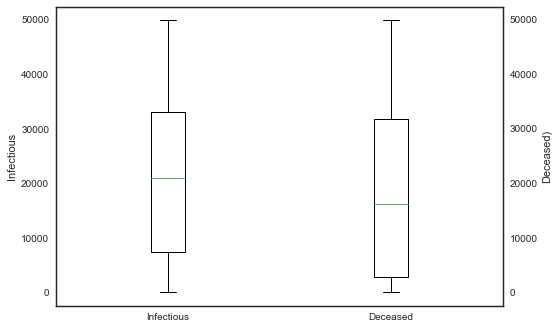

In [6]:
# plot boxplot choosing infectious population and deceased population as objectives
with sns.axes_style('white'):

    fig = plt.figure()

    infect = np.max(outcomes['Infectious population'],axis=1)
    ax_infect = fig.add_subplot(111)
    ax_infect.boxplot([infect,[]])
    ax_infect.set_ylabel('Infectious')

    deceased = np.max(outcomes['Deceased population'],axis=1)
    ax_deceased = ax_infect.twinx()
    ax_deceased.boxplot([[],deceased])
    ax_deceased.set_ylabel('Deceased)')

    ax_deceased.set_xticklabels(['Infectious', 'Deceased'])
#     ax_deceased.set_ylim(ymin=0)

#matplotlib.rcParams['figure.figsize'] = 8, 5
plt.show()

Based on the insights, it can be seen that out of the infectious population, large fraction of them are deceased later on. This shows that there is a room for policy implementation in not only reducing amount of infectious population, but also making sure that the infected population will recover.

After this part, we will be going to PRIM Analysis. For deceased population, approximate mean values of around 15000 people will be taken as threshold. This means that number of deceased population > 1500 is unintended and PRIM will look for subspace for uncertainties which will lead to the objective value range the most.

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > 15000 \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is average number of deceased population.

In [7]:
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Deceased population'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>15000] = 1
    return classes


prim_obj = prim.setup_prim(results, classify, threshold=0.75)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 1000 points remaining, containing 359 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.098, coverage: 0.27298050139275765, density: 1.0 restricted_dimensions: 4.0


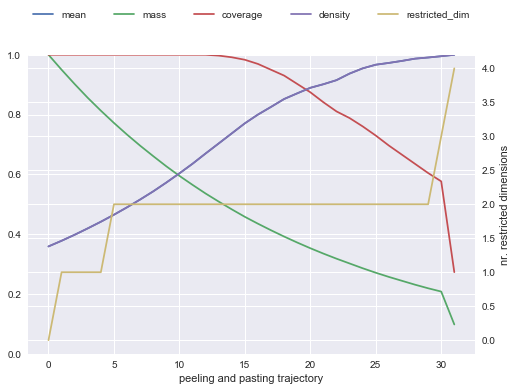

In [9]:
# fig = plt.figure()

# box_1.show_ppt()
# plt.show()

box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

In [10]:
box_1.inspect(18)
box_1.select(18)

coverage    0.930362
density     0.852041
mass        0.392000
mean        0.852041
res dim     2.000000
Name: 18, dtype: float64

                             box 18                        
                                min       max     qp values
Case fatality rate         0.205928  0.499804  4.012180e-42
Basic reproduction number  2.086014  4.996192  2.036035e-30



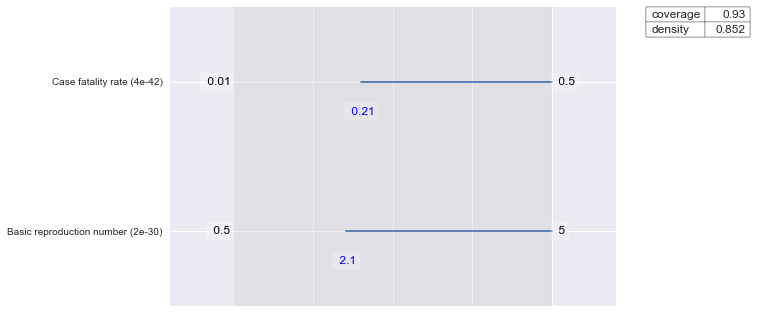

In [11]:
box_1.inspect(style='graph')

Using scenario discovery, we can find a box that contains 93% of all the cases of interest, with a density of 83%. This box shows under which condition the most severe condition of deceased population occurs.

### 1.2.3 Conclustion:
SA: ___Case fatality rate___, ___Basic reproduction number___ and ___Switch SEIR or SIR___ have the most significant influence on results.<br\>
Theoretically, sobol is better than linear regression and morris. Therefore, only sobol will be done in the following models.<br\>

SD: Two variables are shown: basic reproduction number, and case fatality rate. This provides initial insights on policy levers that will be incorporated in the modeling process. Note that the model is basic and will be expanded in the second phase, therefore we can later see whether subspaces of uncertainties will change.

# 2. Model with No Policy

## 2.1 No Policy Model Open Exploration

In [12]:
ema_logging.log_to_stderr(ema_logging.INFO)
# load no policy model using VensimModel
nmodel = VensimModel("Nopolicy", model_file=r'model/SEIR or SIR_NoPolicy_goodtrial.vpm')

In [13]:
#Defining All uncertainties. Most don't apply to the base model, but as policies are introduced, their applicability changes.
nmodel.uncertainties = [RealParameter('Awareness Effect time', 3, 15),
                  RealParameter('Awareness Effectiveness', 0.01, 0.2),
                  RealParameter('Vaccination Effectiveness', 0.1, 0.8),
                  RealParameter('Contact Factor Reduction', 0.01, 0.4),
                  RealParameter('Basic reproduction number', 0.5, 5),
                  RealParameter('Average critical condition and recovery period',5, 15),
                  RealParameter('Average infectious period', 7, 21),
                  RealParameter('Vaccination Speed improvement', 1, 2),
                  RealParameter('Vaccination Speed Non Hygienic', 20, 100),
                  RealParameter('Average incubation time', 0.5, 14),
                  IntegerParameter('Switch SEIR or SIR', 0, 2),
                  RealParameter('Vaccine Preparation and availability time', 30, 120),
                  RealParameter('Case fatality rate reduction', 0.001, 0.01),
                  RealParameter('Case fatality rate', 0.015, 0.55),
                  RealParameter('Recovery Improved', 0, 3),
                  RealParameter('Personnel per case to handle', 2, 4),
                  RealParameter('New Personnel Training Time', 10, 20),
                  RealParameter('Isolation capacity preparation time', 5,10),
                  RealParameter('Fraction of Tracing personnel',0.25, 0.5 ),
                  RealParameter('fraction of staff getting infected',0.01,0.1 ),
                  RealParameter('fraction of recovered population volunteering for personnel',0.05,0.15 ),
                  RealParameter('fraction of susceptible population volunteering for personnel', 0.00001, 0.0001),
                  RealParameter('Disease Detection rate', 0.1, 0.6),
                  RealParameter('Staff costs', 500, 900),
                  RealParameter('Vaccines cost per case',50, 200),
                  RealParameter('Cost for Isolation facilties',75, 300 ),
                  RealParameter('Cost For Advertising',100, 350),
                  RealParameter('Cost for handling deceased',900, 2000),
                  RealParameter('Development cost for vaccines',200, 700),
                  IntegerParameter('Vaccines Dosage', 1,6)
                 ]

# constants have been fixed permanently in the model.

#outcomes as selected by stakeholders
nmodel.outcomes = [TimeSeriesOutcome('Reported Cases'),
                   TimeSeriesOutcome('Deceased population'),
                   TimeSeriesOutcome('Culmulative Project Costs')
                  ]

In [4]:
#Run the Model

# results_n = perform_experiments(nmodel, scenarios= 1000, uncertainty_sampling='lhs')

[MainProcess/INFO] performing 1000 scenarios * 1 policies * 1 model(s) = 1000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 300 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 700 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 900 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] experiments finished


In [5]:
#Save Results
# save_results(results_n, 'results/results_nopolicy.tar.gz')

[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\results\SIERorSIR_NoPolicy.tar.gz


In [6]:
results_n = load_results('results/results_nopolicy.tar.gz')
experiments_n, outcomes_n = results_n

[MainProcess/WARNING] singular matrix


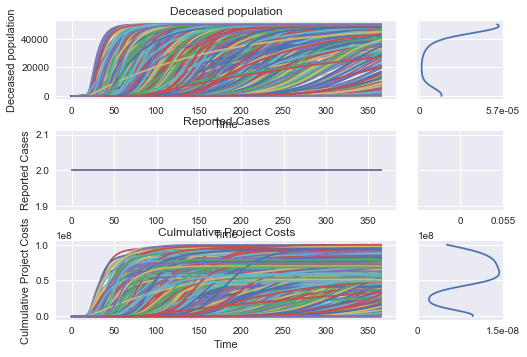

In [7]:
#Plot Results
lines(results_n, outcomes_to_show=['Deceased population', 'Reported Cases', 'Culmulative Project Costs'], density= KDE)
plt.show()

[MainProcess/WARNING] singular matrix


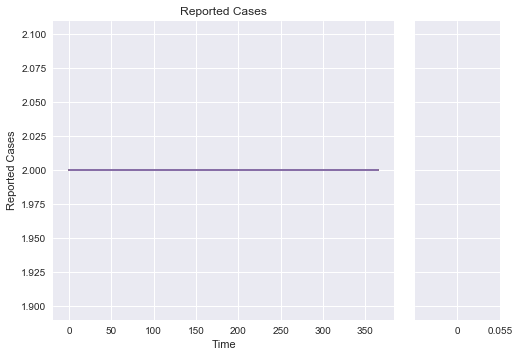

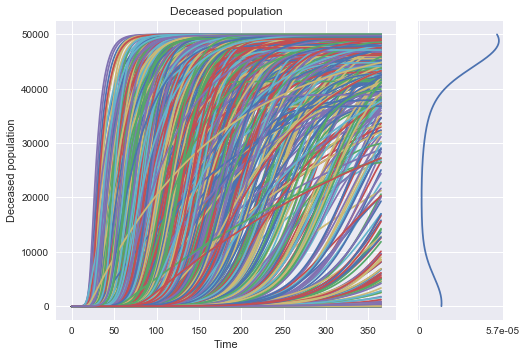

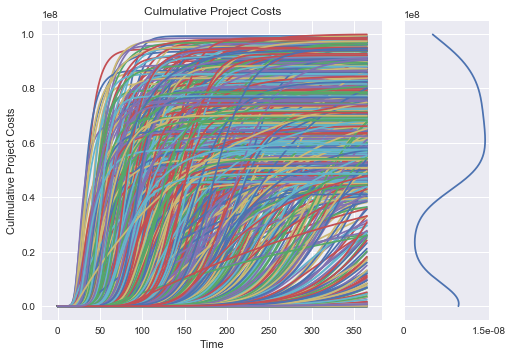

In [41]:
# open exploration for no policy results
outputs = list(results_n[1].keys())[1:]
for x in outputs:
    fig = lines(results_n, outcomes_to_show=[x], density = KDE)
plt.show()

## 2.2 Vulnerability Analysis for No Policy Model (second iteration)

In this part, based on the framework designed, we will run scenario discovery (SD) for the as-is, expanded model. This is to obtain more insights regarding important uncertainties that may later be used to fine-tune the uncertainties range for the final iteration later on.

### 2.2.1 Sensativity Analysis for No Policy Model

### Sobol

In [8]:
# run no policy 
# results_n_so = perform_experiments(nmodel, 500, uncertainty_sampling=SOBOL)
# save_results(results_n_so, 'results/results_nopolicy_sobol.tar.gz')

[MainProcess/INFO] performing 31000 scenarios * 1 policies * 1 model(s) = 31000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 3100 cases completed
[MainProcess/INFO] 6200 cases completed
[MainProcess/INFO] 9300 cases completed
[MainProcess/INFO] 12400 cases completed
[MainProcess/INFO] 15500 cases completed
[MainProcess/INFO] 18600 cases completed
[MainProcess/INFO] 21700 cases completed
[MainProcess/INFO] 24800 cases completed
[MainProcess/INFO] 27900 cases completed
[MainProcess/INFO] 31000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\results\results_n_so.tar.gz


In [9]:
results_n_so = load_results('results/results_nopolicy_sobol.tar.gz')
experiments_so, outcomes_so = results_n_so

In [10]:
# the same way as I did for base model. Here, three objectives are chosen.
exp_so = pd.DataFrame(experiments_so)
out_so_dp = pd.DataFrame(outcomes_so['Deceased population'])
out_so_rc = pd.DataFrame(outcomes_so['Reported Cases'])
out_so_cpc = pd.DataFrame(outcomes_so['Culmulative Project Costs'])
expdrop_so=exp_so.drop(['scenario_id','policy','model'],axis=1)
X_so=expdrop_so.as_matrix(columns=None)
Y_so_dp = list(out_so_dp[360])
Y_so_rc = list(out_so_rc[360])
Y_so_cpc = list(out_so_cpc[360])
Y_so_dp = np.asarray(Y_so_dp)
Y_so_rc = np.asarray(Y_so_rc)
Y_so_cpc = np.asarray(Y_so_cpc)

In [11]:
# uncertainties sensativity towards deceased population in no policy model 
problem = get_SALib_problem(nmodel.uncertainties)
Si = SALib.analyze.sobol.analyze(problem, Y_so_dp, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Average critical condition and recovery period 0.061857 0.072052 0.187306 0.048813
Average incubation time 0.002068 0.017495 0.021325 0.011515
Average infectious period 0.074092 0.061410 0.194822 0.051857
Awareness Effect time 0.000000 0.000000 0.000000 0.000000
Awareness Effectiveness 0.000000 0.000000 0.000000 0.000000
Basic reproduction number 0.567727 0.117711 0.797732 0.112787
Case fatality rate 0.116432 0.070381 0.296025 0.065218
Case fatality rate reduction 0.000000 0.000000 0.000000 0.000000
Contact Factor Reduction 0.000000 0.000000 0.000000 0.000000
Cost For Advertising 0.000000 0.000000 0.000000 0.000000
Cost for Isolation facilties 0.000000 0.000000 0.000000 0.000000
Cost for handling deceased 0.000000 0.000000 0.000000 0.000000
Development cost for vaccines 0.000000 0.000000 0.000000 0.000000
Disease Detection rate 0.000000 0.000000 0.000000 0.000000
Fraction of Tracing personnel 0.000000 0.000000 0.000000 0.000000
Isolation capacity prepara

In [12]:
# uncertainties sensativity towards reported cases in no policy model 
Si = SALib.analyze.sobol.analyze(problem, Y_so_rc, print_to_console=True)

D:\Anaconda3\lib\site-packages\SALib\analyze\sobol.py:87: RuntimeWarning: invalid value encountered in true_divide
  Y = (Y - Y.mean())/Y.std()


Parameter S1 S1_conf ST ST_conf
Average critical condition and recovery period nan nan nan nan
Average incubation time nan nan nan nan
Average infectious period nan nan nan nan
Awareness Effect time nan nan nan nan
Awareness Effectiveness nan nan nan nan
Basic reproduction number nan nan nan nan
Case fatality rate nan nan nan nan
Case fatality rate reduction nan nan nan nan
Contact Factor Reduction nan nan nan nan
Cost For Advertising nan nan nan nan
Cost for Isolation facilties nan nan nan nan
Cost for handling deceased nan nan nan nan
Development cost for vaccines nan nan nan nan
Disease Detection rate nan nan nan nan
Fraction of Tracing personnel nan nan nan nan
Isolation capacity preparation time nan nan nan nan
New Personnel Training Time nan nan nan nan
Personnel per case to handle nan nan nan nan
Recovery Improved nan nan nan nan
Staff costs nan nan nan nan
Switch SEIR or SIR nan nan nan nan
Vaccination Effectiveness nan nan nan nan
Vaccination Speed Non Hygienic nan nan nan nan

In [13]:
# uncertainties sensativity towards cumulative projects costs in no policy model 
Si = SALib.analyze.sobol.analyze(problem, Y_so_cpc, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Average critical condition and recovery period 0.041762 0.059650 0.176254 0.050662
Average incubation time 0.002461 0.019339 0.019907 0.012338
Average infectious period 0.055110 0.053968 0.172333 0.045513
Awareness Effect time 0.000000 0.000000 0.000000 0.000000
Awareness Effectiveness 0.000000 0.000000 0.000000 0.000000
Basic reproduction number 0.473753 0.094478 0.682212 0.099296
Case fatality rate 0.089529 0.067620 0.244016 0.060896
Case fatality rate reduction 0.000000 0.000000 0.000000 0.000000
Contact Factor Reduction 0.000000 0.000000 0.000000 0.000000
Cost For Advertising 0.000000 0.000000 0.000000 0.000000
Cost for Isolation facilties 0.000000 0.000000 0.000000 0.000000
Cost for handling deceased 0.142182 0.053226 0.188967 0.030453
Development cost for vaccines 0.000000 0.000000 0.000000 0.000000
Disease Detection rate 0.000000 0.000000 0.000000 0.000000
Fraction of Tracing personnel 0.000000 0.000000 0.000000 0.000000
Isolation capacity prepara

Deceased population, S1 ranking:<br\>
___Basic reproduction number > Case fatality rate Non Quarantined > Average infectious period<br\>___
Reported Cases, __no results__<br\>
Culmulative Project Costs, S1 ranking:<br\>
___Basic reproduction number > Average infectious period > Average critical condition and recovery period___

### 2.2.2 Scenario Discovery for No Policy Model

In [14]:
# load no policy model results in order to save RAM
results = load_results('results/results_nopolicy.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\Python\epa1361_open-master\final assignment\results\results_nopolicy.tar.gz


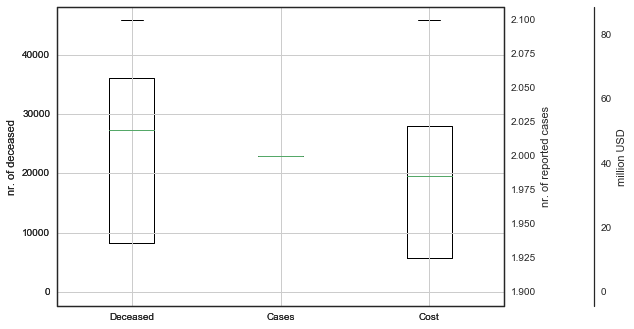

In [16]:
# draw boxplot for three objectives in a graph
with sns.axes_style('white'):
    oois = outcomes.keys()
    oois = list(oois)
    oois.pop(oois.index('Culmulative Project Costs'))
    data = []

    for ooi in oois:
        value = outcomes[ooi]
        if len(value.shape)>1:
            value = np.sum(value, axis=1)
        value = value/np.max(value)
        data.append(value)

#     fig = plt.figure()

    dp = np.mean(outcomes['Deceased population'],axis=1)
    ax_dp = host_subplot(111, axes_class=AA.Axes)
    ax_dp.boxplot([dp,[],[]])
    ax_dp.set_ylabel('nr. of deceased')

    rc = np.mean(outcomes['Reported Cases'],axis=1)
    ax_rc = ax_dp.twinx()
    ax_rc.boxplot([[],rc,[]])
    ax_rc.set_ylabel('nr. of reported cases')
    
    cpc = np.mean(outcomes['Culmulative Project Costs'],axis=1)/1000000
    ax_cpc = ax_dp.twinx()
    offset = 90
    
    new_fixed_axis = ax_cpc.get_grid_helper().new_fixed_axis
    ax_cpc.axis["right"] = new_fixed_axis(loc="right",
                                          axis_direction='right',
                                          axes=ax_cpc,
                                          offset=(offset, 0))
    
    ax_cpc.axis["right"].toggle(all=True)
    ax_cpc.boxplot([[],[],cpc])
    ax_cpc.set_ylabel('million USD')

    ax_dp.set_xticklabels(['Deceased', 'Cases','Cost'])
#     ax_dp.set_ylim(ymin=0)
    ax_dp.grid(True)
    
    plt.subplots_adjust(wspace = .75)

plt.show()


The next question is then, under which combination of developments do we observe a high amount of cost and deceased population? 
To simplify this question, we first will see correlation between cost and deceased population. 
If this correlation is high, we might be able to use only one or the other. Since the reported cases number is significantly low and static in the Expanded Model with no policies, correlation between reported cases and other objectives will currently be ignored.

In [17]:
cpc1 = cpc*1000000
linregress(cpc1, dp)

LinregressResult(slope=0.00059696164800938098, intercept=3206.0353182069884, rvalue=0.92804750313819084, pvalue=0.0, stderr=7.5839027075588301e-06)

Since there is a statistically significant correlation (where r-value is 0.92) between cumulative cost and deceased population, we can thus simplify the scenario discovery by using either one of the two objectives. For now, we will use deceased population.


Firstly, we will set the threshold based on the approximate average value of deceased population. 25000 will be set.

. 

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > mean \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is average number of deceased population.


In [18]:
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Deceased population'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>25000] = 1
    return classes


prim_obj = prim.setup_prim(results, classify, threshold=0.75)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 1000 points remaining, containing 546 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.187, coverage: 0.3424908424908425, density: 1.0 restricted_dimensions: 5.0


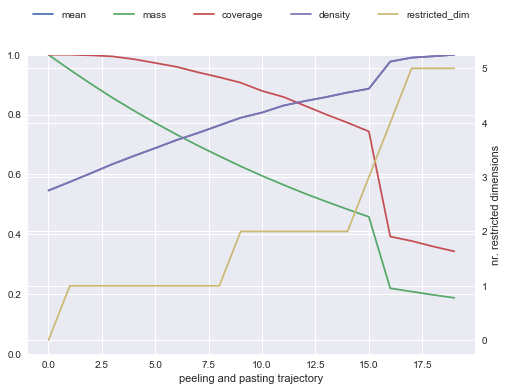

In [19]:
# fig = plt.figure()
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

In [20]:
box_1.inspect(11)
box_1.select(11)

coverage    0.858974
density     0.830088
mass        0.565000
mean        0.830088
res dim     2.000000
Name: 11, dtype: float64

                             box 11                        
                                min       max     qp values
Basic reproduction number  2.322558  4.996530  1.732311e-39
Case fatality rate         0.046158  0.549756  8.804135e-02



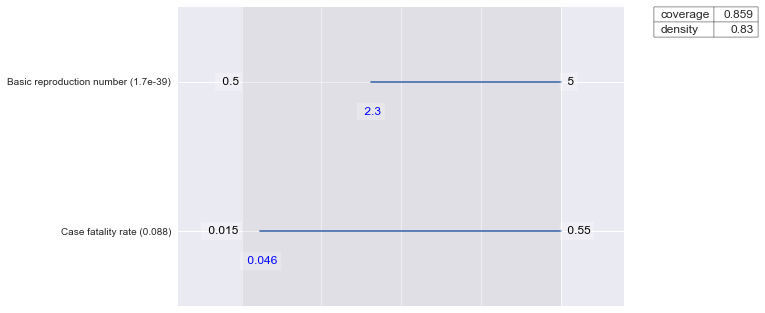

In [21]:
box_1.inspect(style='graph')

Using scenario discovery, we can find a box that contains 81% coverage and 83% density. This box shows under which condition the most severe condition of deceased population occurs.

Two variables are shown: basic reproduction number, and case fatality rate.

Now, considering that current mean value of 23000 might be too large a fraction given the initial number of population (which is 100000), now 0.1% fraction of population will instead be considered as threshold. This means threshold is set as 100. The whole process will then be repeated to see any possible change of the uncertainties subspace.

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > 1000 \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is average number of deceased population.


In [22]:
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Deceased population'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>100] = 1
    return classes


prim_obj = prim.setup_prim(results, classify, threshold=0.75)
box_1 = prim_obj.find_box()


[MainProcess/INFO] 1000 points remaining, containing 840 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.483, coverage: 0.575, density: 1.0 restricted_dimensions: 4.0


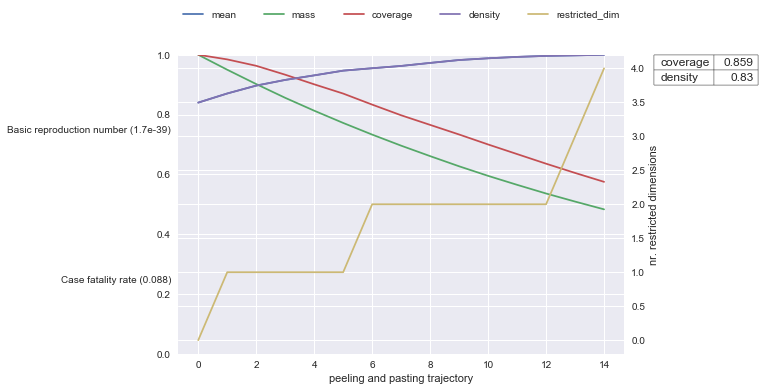

In [23]:
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

coverage    0.933333
density     0.915888
mass        0.856000
mean        0.915888
res dim     1.000000
Name: 3, dtype: float64

                              box 3                       
                                min      max     qp values
Basic reproduction number  1.147915  4.99653  4.247663e-11



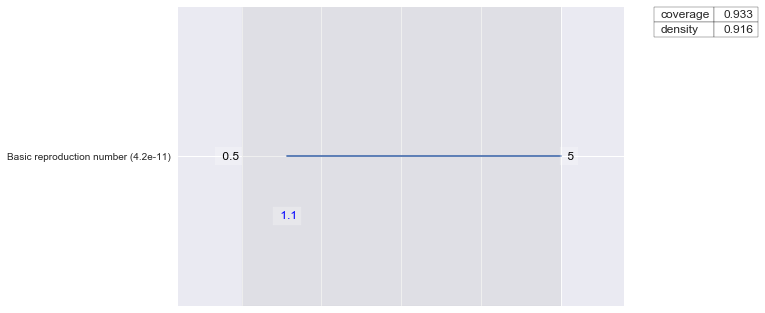

In [24]:
box_1.inspect(3)
box_1.select(3)
box_1.inspect(style='graph')

### 2.2.3 Conclustion:
SA: ___Basic reproduction number___ and ___Average infectious period___ are crucial in two objectives.<br/>

SD: Narrowing down the range of objective values turns out to also narrowing the focus of uncertainty to Basic Reproduction Number. The significantly high density and coverage justifies the result. 

Note: In hindsight, based on our further analysis and comparison with Scenario Discovery result of the third iteration, the subspace result hardly creates difference for similarly high density and coverage profile. Therefore, it is concluded that Scenario Discovery at 2nd iteration does not generate additional insight for decision analysis. However, the framework will be maintained as it is, since this particular result is case-specific while the whole approach can be applied to other cases. This is also motivated in the report.

# 3. All Policies On Architecture

## 3.1 Open Exploration for All Policies Model

In [25]:
#Import Model Ensembles. Each Model is a policy implmentation. The models are called so that levers can be samples over them
ema_logging.log_to_stderr(ema_logging.INFO)

amodel = VensimModel("AllPolicy", model_file=r'model/SEIR or SIR_AllPolicy_goodtrial.vpm')

In [26]:
#Defining All uncertainties. Most don't apply to the base model, but as policies are introduced, their applicability changes.
amodel.uncertainties = [RealParameter('Awareness Effect time', 3, 15),
                  RealParameter('Awareness Effectiveness', 0.01, 0.2),
                  RealParameter('Vaccination Effectiveness', 0.1, 0.8),
                  RealParameter('Contact Factor Reduction', 0.01, 0.4),
                  RealParameter('Basic reproduction number', 0.5, 5),
                  RealParameter('Average critical condition and recovery period',5, 15),
                  RealParameter('Average infectious period', 7, 21),
                  RealParameter('Vaccination Speed improvement', 1, 2),
                  RealParameter('Vaccination Speed Non Hygienic', 20, 100),
                  RealParameter('Average incubation time', 0.5, 14),
                  IntegerParameter('Switch SEIR or SIR', 0, 2),
                  RealParameter('Vaccine Preparation and availability time', 30, 120),
                  RealParameter('Case fatality rate reduction', 0.001, 0.01),
                  RealParameter('Case fatality rate', 0.015, 0.55),
                  RealParameter('Recovery Improved', 0, 3),
                  RealParameter('Personnel per case to handle', 2, 4),
                  RealParameter('New Personnel Training Time', 10, 20),
                  RealParameter('Isolation capacity preparation time', 5,10),
                  RealParameter('Fraction of Tracing personnel',0.25, 0.5 ),
                  RealParameter('fraction of staff getting infected',0.01,0.1 ),
                  RealParameter('fraction of recovered population volunteering for personnel',0.05,0.15 ),
                  RealParameter('fraction of susceptible population volunteering for personnel', 0.00001, 0.0001),
                  RealParameter('Disease Detection rate', 0.1, 0.6),
                  RealParameter('Staff costs', 500, 900),
                  RealParameter('Vaccines cost per case',50, 200),
                  RealParameter('Cost for Isolation facilties',75, 300 ),
                  RealParameter('Cost For Advertising',100, 350),
                  RealParameter('Cost for handling deceased',900, 2000),
                  RealParameter('Development cost for vaccines',200, 700),
                  IntegerParameter('Vaccines Dosage', 1,6)
                 ]

#Defining Policy levers irrespective of Policy. Policy on and Off Changes the applicability of a certain lever
amodel.levers = [RealParameter('Proactive starting time', 30, 365),
          RealParameter('Isolation Scale up Start Time', 10, 365),
          RealParameter('Hygiene program start time', 10, 365),
          RealParameter('Vaccination Program Start time', 10, 365),                 
          RealParameter('Fraction of additional personnel as proactiveness', 0.2, 1),
          RealParameter('Fraction of Additional capacity as proactiveness', 0.2, 1),
          RealParameter('Average Staff commisioning time', 30, 365),
          RealParameter('Facility commisioning time', 30, 365)
         ]
# constants have been fixed permanently in the model.

#outcomes as selected by stakeholders
amodel.outcomes = [TimeSeriesOutcome('Reported Cases'),
            TimeSeriesOutcome('Deceased population'),
            TimeSeriesOutcome('Culmulative Project Costs')
           ]

In [27]:
# Create Policies over all models using levers
class Character(object):
    '''returns a character in the order of the alphabet
    
    ..note:: will fail if we get past 26 calls
    
    '''

    def __init__(self):
        self.counter = -1
        
    def __call__(self, kwargs):
        self.counter += 1
        return chr(ord('a') + self.counter)
    
policies_a = sample_levers(amodel, n_samples= 5, name=Character())

In [36]:
#Run Multipolicy Ensemble
# results_a = perform_experiments(amodel, scenarios= 1000, policies= policies_a, uncertainty_sampling='lhs')

[MainProcess/INFO] performing 1000 scenarios * 5 policies * 1 model(s) = 5000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1500 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] 2500 cases completed
[MainProcess/INFO] 3000 cases completed
[MainProcess/INFO] 3500 cases completed
[MainProcess/INFO] 4000 cases completed
[MainProcess/INFO] 4500 cases completed
[MainProcess/INFO] 5000 cases completed
[MainProcess/INFO] experiments finished


In [38]:
#save the results into a .gz file
# save_results(results_a, 'results/results_allpolicies.tar.gz')

[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\results\results_a.tar.gz


In [37]:
#for analysis purpose to be used later
results_a = load_results('results/results_allpocilies.tar.gz')
experiments, outcomes = results_a

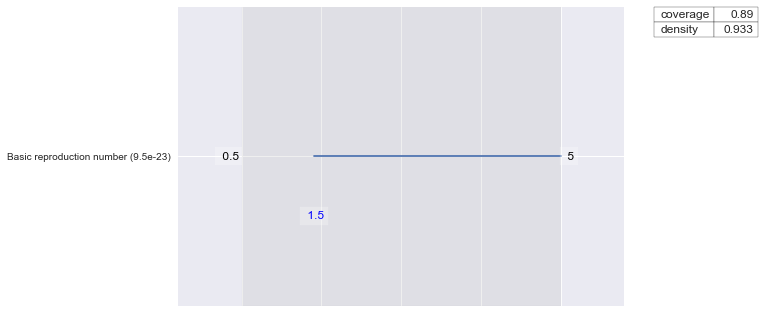

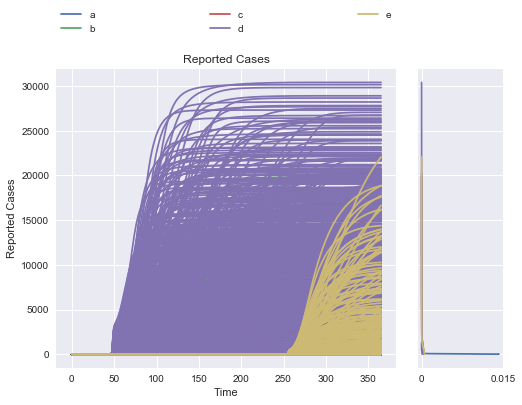

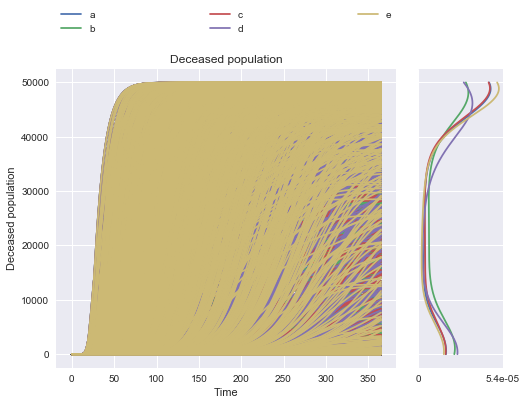

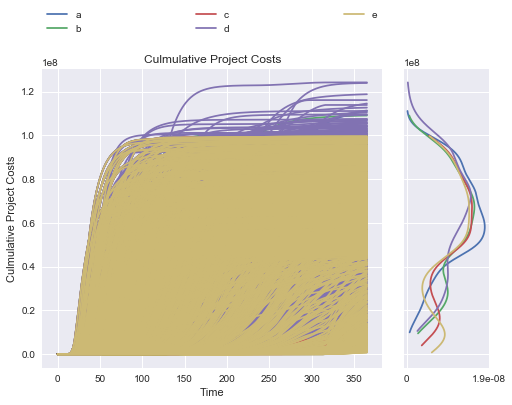

In [39]:
# spaghetti graphs for open exploration of uncertainties in all policies model
outputs = list(results_a[1].keys())[1:]
for x in outputs:
    fig = lines(results_a, outcomes_to_show=[x], density = KDE, group_by='policy')
plt.show()

## 3.2 Vulnerability Analysis for All Policies Model (third iteration)

At the third iteration, we will look into the Expanded Model with all policies implemented. Compared to previous result of Scenario Discovery, we will fine-tune the subspace of the most pivotal uncertainty(-ies) that can hinder the effectiveness of all implemented policies to improve the objectives.

### 3.2.1 Sensativity Analysis for All Policies Model

### Sobol

In [9]:
# run and save sobol results of all policies model
# results_a_so = perform_experiments(amodel, 100, policies= policies_a, uncertainty_sampling=SOBOL)
# save_results(results_a_so, r'results/results_a_so.tar.gz')
# save_results(results_a_so, 'results_allpolicies_sobol.tar.gz')

[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\model\results_a_so.tar.gz


In [5]:
# load the sobol results
results_a_so = load_results('results/results_allpolicies_sobol.tar.gz')

[MainProcess/INFO] results loaded succesfully from D:\Python\epa1361_open-master\final assignment\results\results_allpolicies_sobol.tar.gz


In [6]:
experiments_so, outcomes_so = results_a_so

In [7]:
# same as I did before, trim the experiments and outcomes for SALib inputs.
exp_so = pd.DataFrame(experiments_so)
out_so_dp = pd.DataFrame(outcomes_so['Deceased population'])
out_so_rc = pd.DataFrame(outcomes_so['Reported Cases'])
out_so_cpc = pd.DataFrame(outcomes_so['Culmulative Project Costs'])
expdrop_so=exp_so.drop(['scenario_id','policy','model'],axis=1)
X_so=expdrop_so.as_matrix(columns=None)
Y_so_dp = list(out_so_dp[360])
Y_so_rc = list(out_so_rc[360])
Y_so_cpc = list(out_so_cpc[360])
Y_so_dp = np.asarray(Y_so_dp)
Y_so_rc = np.asarray(Y_so_rc)
Y_so_cpc = np.asarray(Y_so_cpc)

In [8]:
# uncertainties sensativity towards deceased population in all policies model
problem = get_SALib_problem(amodel.uncertainties)
Si = SALib.analyze.sobol.analyze(problem, Y_so_dp, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Average critical condition and recovery period -0.018407 0.058480 0.143345 0.040733
Average incubation time 0.005754 0.013456 0.014218 0.006599
Average infectious period -0.077251 0.067161 0.275365 0.046791
Awareness Effect time -0.000213 0.002926 0.000747 0.000890
Awareness Effectiveness -0.003959 0.003167 0.001359 0.001406
Basic reproduction number 0.495718 0.092375 0.693225 0.091108
Case fatality rate -0.040928 0.052951 0.290863 0.058728
Case fatality rate reduction 0.000166 0.000296 0.000008 0.000006
Contact Factor Reduction -0.003931 0.004282 0.002952 0.003220
Cost For Advertising 0.000000 0.000000 0.000000 0.000000
Cost for Isolation facilties 0.000000 0.000000 0.000000 0.000000
Cost for handling deceased 0.000000 0.000000 0.000000 0.000000
Development cost for vaccines 0.000000 0.000000 0.000000 0.000000
Disease Detection rate 0.003422 0.013026 0.012666 0.005807
Fraction of Tracing personnel 0.001761 0.004830 0.001142 0.001081
Isolation capacity p

In [9]:
# uncertainties sensativity towards reported cases in all policies model
Si = SALib.analyze.sobol.analyze(problem, Y_so_rc, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Average critical condition and recovery period 0.045800 0.081881 0.181077 0.088000
Average incubation time -0.015300 0.062027 0.117148 0.055374
Average infectious period 0.079145 0.135150 0.375766 0.097578
Awareness Effect time -0.002437 0.002442 0.000351 0.000255
Awareness Effectiveness -0.002105 0.002622 0.000775 0.000635
Basic reproduction number 0.149606 0.142188 0.490480 0.137555
Case fatality rate 0.031130 0.133771 0.506180 0.131581
Case fatality rate reduction 0.000118 0.000228 0.000003 0.000003
Contact Factor Reduction -0.001454 0.002480 0.001494 0.001384
Cost For Advertising 0.000000 0.000000 0.000000 0.000000
Cost for Isolation facilties 0.000000 0.000000 0.000000 0.000000
Cost for handling deceased 0.000000 0.000000 0.000000 0.000000
Development cost for vaccines 0.000000 0.000000 0.000000 0.000000
Disease Detection rate 0.122275 0.086560 0.165100 0.063027
Fraction of Tracing personnel 0.008828 0.028791 0.018463 0.010507
Isolation capacity pre

In [10]:
# uncertainties sensativity towards cumulative projects costs in all policies model
Si = SALib.analyze.sobol.analyze(problem, Y_so_cpc, print_to_console=True)

Parameter S1 S1_conf ST ST_conf
Average critical condition and recovery period -0.011473 0.068349 0.156194 0.052750
Average incubation time -0.005196 0.014966 0.008650 0.004581
Average infectious period -0.073867 0.049865 0.173155 0.056065
Awareness Effect time 0.003165 0.010557 0.005934 0.001541
Awareness Effectiveness 0.024131 0.024176 0.023128 0.005618
Basic reproduction number 0.278571 0.093654 0.537615 0.100430
Case fatality rate -0.080627 0.052462 0.236722 0.048416
Case fatality rate reduction 0.001963 0.001497 0.000098 0.000045
Contact Factor Reduction -0.000597 0.005968 0.003446 0.004666
Cost For Advertising 0.006847 0.020430 0.021210 0.003875
Cost for Isolation facilties -0.000051 0.001580 0.000219 0.000138
Cost for handling deceased 0.175498 0.056318 0.230719 0.041044
Development cost for vaccines -0.025150 0.022432 0.027367 0.009572
Disease Detection rate 0.001730 0.010117 0.007110 0.004315
Fraction of Tracing personnel 0.005134 0.008844 0.003626 0.004082
Isolation capacity 

Deceased population, S1 ranking:<br\>
___Basic reproduction number > Average infectious period > Case fatality rate<br\>___
Reported Cases, S1 ranking<br\>
___Basic reproduction number > Disease Detection rate > Average infectious period<br\>___
Culmulative Project Costs, S1 ranking:<br\>
___Basic reproduction number > Cost for handling deceased > Case fatality rate___

### 3.2.2 Scenario Discovery for All Policies Model

In [28]:
results = load_results('results/results_allpolicies.tar.gz')
experiments, outcomes = results

[MainProcess/INFO] results loaded succesfully from D:\Python\epa1361_open-master\final assignment\results\results_allpolicies.tar.gz


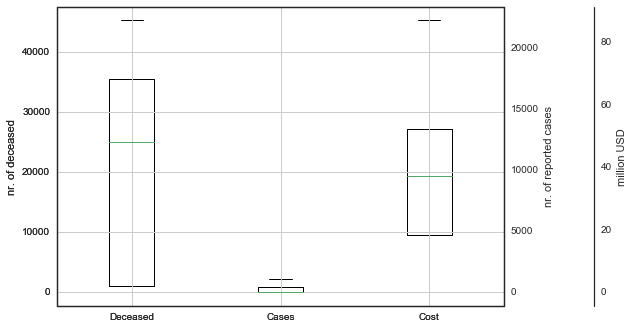

In [30]:
# draw boxplot for three objectives in a graph
with sns.axes_style('white'):
    oois = outcomes.keys()
    oois = list(oois)
    oois.pop(oois.index('Culmulative Project Costs'))
    data = []

    for ooi in oois:
        value = outcomes[ooi]
        if len(value.shape)>1:
            value = np.sum(value, axis=1)
        value = value/np.max(value)
        data.append(value)

#     fig = plt.figure()

    dp = np.mean(outcomes['Deceased population'],axis=1)
    ax_dp = host_subplot(111, axes_class=AA.Axes)
    ax_dp.boxplot([dp,[],[]])
    ax_dp.set_ylabel('nr. of deceased')

    rc = np.mean(outcomes['Reported Cases'],axis=1)
    ax_rc = ax_dp.twinx()
    ax_rc.boxplot([[],rc,[]])
    ax_rc.set_ylabel('nr. of reported cases')
    
    cpc = np.mean(outcomes['Culmulative Project Costs'],axis=1)/1000000
    ax_cpc = ax_dp.twinx()
    offset = 90
    
    new_fixed_axis = ax_cpc.get_grid_helper().new_fixed_axis
    ax_cpc.axis["right"] = new_fixed_axis(loc="right",
                                          axis_direction='right',
                                          axes=ax_cpc,
                                          offset=(offset, 0))
    
    ax_cpc.axis["right"].toggle(all=True)
    ax_cpc.boxplot([[],[],cpc])
    ax_cpc.set_ylabel('million USD')

    ax_dp.set_xticklabels(['Deceased', 'Cases','Cost'])
#     ax_dp.set_ylim(ymin=0)
    ax_dp.grid(True)
    
    plt.subplots_adjust(wspace = .75)

plt.show()

In [31]:
dead_allpolicy = np.array(dp)
print('deceased population =', dead_allpolicy)

costs_allpolicy= np.array(cpc)
print('total cost =', costs_allpolicy)

cases_allpolicy = np.array(rc)
print('total case =',cases_allpolicy)

deceased population = [  2.18564147e+04   3.08115259e+00   1.21875984e+00 ...,   5.12409407e+00
   3.70817370e+04   2.64118874e+00]
total cost = [ 46.62227256  39.97525941   5.26640142 ...,   0.30920675  70.32855423
   0.57997653]
total case = [ 2.00976255  2.          2.         ...,  2.43597645  2.          2.00566324]


In [32]:
dead_cost = linregress(dead_allpolicy,costs_allpolicy)
dead_case = linregress(dead_allpolicy,cases_allpolicy)
case_cost = linregress(cases_allpolicy,costs_allpolicy)
print('dead-cost regression = ', dead_cost)
print('dead-case regression = ', dead_case)
print('case-cost regression = ', case_cost)

dead-cost regression =  LinregressResult(slope=0.0011705888105097593, intercept=11.762783918970737, rvalue=0.86769867381181864, pvalue=0.0, stderr=9.4857748638619745e-06)
dead-case regression =  LinregressResult(slope=0.013030493762705061, intercept=928.76766199772806, rvalue=0.069948322923664472, pvalue=7.3862942782070296e-07, stderr=0.0026285750524509383)
case-cost regression =  LinregressResult(slope=0.001216182589643794, intercept=34.921374010418212, rvalue=0.16793720215364458, pvalue=5.9682517459944761e-33, stderr=0.00010098143571070414)


From the linear regression plotting, it is shown that deceased population & cumulative costs have strong correlation (0.8), as discussed earlier with no-policies-implemented model. However, correlation is weak as regards to deceased population & reported cases, as well as reported cases & cumulative costs. All in all, this result implies that it is necessary to search for subspace for uncertainties given threshold of all three objectives values.

Now, we will go for PRIM analysis for deceased population. Same threshold will be taken as before, which is 100 persons.

In [33]:
ema_logging.log_to_stderr(ema_logging.INFO)

def classify(data):
    ooi = 'Deceased population'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>100] = 1
    return classes


prim_obj = prim.setup_prim(results, classify, threshold=0.75)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 5000 points remaining, containing 4021 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.3136, coverage: 0.38995274807261876, density: 1.0 restricted_dimensions: 8.0


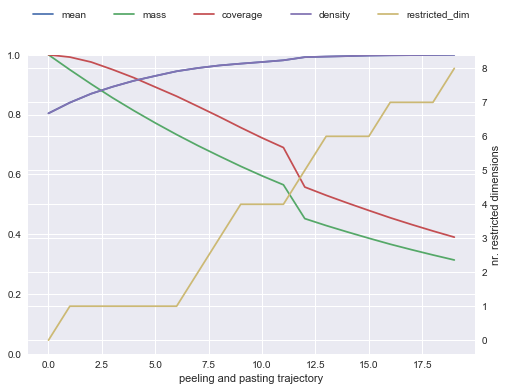

In [34]:
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

In [35]:
box_1.inspect(3)
box_1.select(3)

coverage    0.950510
density     0.892991
mass        0.856000
mean        0.892991
res dim     1.000000
Name: 3, dtype: float64

                              box 3                        
                                min       max     qp values
Basic reproduction number  1.149207  4.999008  8.468479e-56



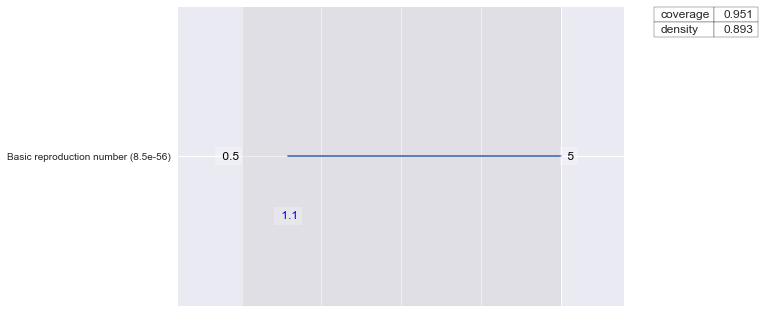

In [36]:
box_1.inspect(style='graph')

Now, same process is committed for Cumulative Project Costs. For this objective, approximate mean value is taken as threshold.

$
f(x) = 
    \begin{cases}
        1 & \text{if } x > mean \\
        0 & \text{otherwise}
    \end{cases}
$$
$

where $x$ is average number of cumulative cost.

In [37]:
def classify(data):
    ooi = 'Culmulative Project Costs'
    outcome = np.mean(outcomes[ooi], axis=1)
    classes = np.zeros(outcome.shape[0])
    classes[outcome>40000000] = 1
    return classes


prim_obj = prim.setup_prim(results, classify, threshold=0.75)
box_1 = prim_obj.find_box()

[MainProcess/INFO] 5000 points remaining, containing 2256 cases of interest
[MainProcess/INFO] mean: 1.0, mass: 0.111, coverage: 0.24601063829787234, density: 1.0 restricted_dimensions: 9.0


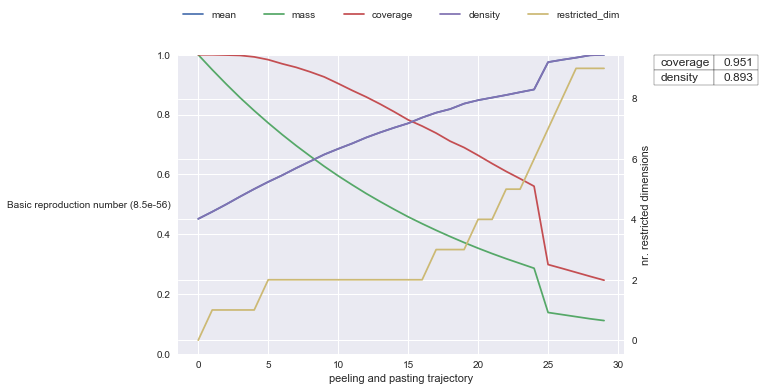

In [38]:
box_1.show_ppt()
plt.show()
box_1.show_tradeoff()
mpld3.display()

In [39]:
box_1.inspect(9)
box_1.select(9)

coverage    0.925975
density     0.666348
mass        0.627000
mean        0.666348
res dim     2.000000
Name: 9, dtype: float64

                                  box 9                           
                                    min          max     qp values
Basic reproduction number      1.710389     4.999008  8.343012e-67
Cost for handling deceased  1070.868840  1999.487405  3.214173e-17



### 3.2.3 Conclusion:
SA: Based on the results from sensativity analysis, ___Basic reproduction number___ is dominating. ___Case fatality rate___ and ___Average infectious period___ also have significent influence on objectives.

SD: Given the highest combination possible of density and coverage result of PRIM analysis with the two objectives, Basic Reproduction Number turned out to be the most important uncertainty. It can also be seen that the subspace is narrowed. This range is what will be used to fine-tune the uncertainty as to be run later on in Multi Objective Robust Decision Making.

For Cumulative Cost, Basic reproduction number range is 1.52 to 5. While for Deceased Population, the range is 1.15 to 5. For the final range of fine-tuned uncertainty, therefore, Basic Reproduction Number parameter uncertainty scope is changed to 1.15 to 5.

## 3.3 Robust Optimization (If Not used Manual Objectives)

In [31]:
#Import Model for Analysis - All Policies On
ema_logging.log_to_stderr(ema_logging.INFO)
vmodel = VensimModel('RobustOptimisationPhase2', model_file="results/SEIR or SIR_AllPolicy_goodtrial.vpm" )

### Robust Optimisation Function Architecture

In [32]:
#Defining All uncertainties. Most don't apply to the base model, but as policies are introduced, their applicability changes.
vmodel.uncertainties = [RealParameter('Awareness Effect time', 3, 15),
                  RealParameter('Awareness Effectiveness', 0.01, 0.2),
                  RealParameter('Vaccination Effectiveness', 0.1, 0.8),
                  RealParameter('Contact Factor Reduction', 0.01, 0.4),
                  RealParameter('Basic reproduction number', 0.5, 5),
                  RealParameter('Average critical condition and recovery period',5, 15),
                  RealParameter('Average infectious period', 7, 21),
                  RealParameter('Vaccination Speed improvement', 1, 2),
                  RealParameter('Vaccination Speed Non Hygienic', 20, 100),
                  RealParameter('Average incubation time', 0.5, 14),
                  IntegerParameter('Switch SEIR or SIR', 0, 2),
                  RealParameter('Vaccine Preparation and availability time', 30, 120),
                  RealParameter('Case fatality rate reduction', 0.001, 0.01),
                  RealParameter('Case fatality rate', 0.015, 0.55),
                  RealParameter('Recovery Improved', 0, 3),
                  RealParameter('Personnel per case to handle', 2, 4),
                  RealParameter('New Personnel Training Time', 10, 20),
                  RealParameter('Isolation capacity preparation time', 5,10),
                  RealParameter('Fraction of Tracing personnel',0.25, 0.5 ),
                  RealParameter('fraction of staff getting infected',0.01,0.1 ),
                  RealParameter('fraction of recovered population volunteering for personnel',0.05,0.15 ),
                  RealParameter('fraction of susceptible population volunteering for personnel', 0.00001, 0.0001),
                  RealParameter('Disease Detection rate', 0.1, 0.6),
                  RealParameter('Staff costs', 500, 900),
                  RealParameter('Vaccines cost per case',50, 200),
                  RealParameter('Cost for Isolation facilties',75, 300 ),
                  RealParameter('Cost For Advertising',100, 350),
                  RealParameter('Cost for handling deceased',900, 2000),
                  RealParameter('Development cost for vaccines',200, 700),
                  IntegerParameter('Vaccines Dosage', 1,6)
                 ]

#Defining Policy levers irrespective of Policy. Policy on and Off Changes the applicability of a certain lever
vmodel.levers = [RealParameter('Proactive starting time', 30, 365),
          RealParameter('Isolation Scale up Start Time', 10, 365),
          RealParameter('Hygiene program start time', 10, 365),
          RealParameter('Vaccination Program Start time', 10, 365),                 
          RealParameter('Fraction of additional personnel as proactiveness', 0.2, 1),
          RealParameter('Fraction of Additional capacity as proactiveness', 0.2, 1),
          RealParameter('Average Staff commisioning time', 30, 365),
          RealParameter('Facility commisioning time', 30, 365)
         ]
# constants have been fixed permanently in the model.

#outcomes as selected by stakeholders
vmodel.outcomes = [TimeSeriesOutcome('Reported Cases'),
            TimeSeriesOutcome('Deceased population'),
            TimeSeriesOutcome('Culmulative Project Costs')
           ]
#Define the Objectives
MAXIMIZE = ScalarOutcome.MAXIMIZE  # @UndefinedVariable
MINIMIZE = ScalarOutcome.MINIMIZE  # @UndefinedVariable

#Define the robustness function for each objective
vmodel_rob.robustnes_functions = [ScalarOutcome('Reported Cases' , kind=MINIMIZE, function=np.max),
                                  ScalarOutcome('Deceased population', kind=MINIMIZE, function=np.max),
                                  ScalarOutcome('Culmulative Project Costs', kind=MINIMIZE, function=np.max)
                                 ]

### Robust Optimisation Run - Platypus

The optimisation run primarily focuses on generating insights on the influence of uncertainties on stakeholder Objectives in the presence of Policies. This means that the entire policy structure is On and the sampler will create random policy combinations from the available levers and test it for objective definitions. 
A point to note here is that the quality of insight is dependant on the number of experiments generated. For this case, we use 1250 experiments, which is not ideal. the objective possible values obtained here will only provide additional insights to the stakeholders for fixing objectives more realistically to fine tune uncertainties over scenarios (Scenario discovery to follow again). The data will be compared with Uncertainty ranks in absence of policies and a better informed choice of objectives will be made for further analysis. Refer report for framework.

In [33]:
#Defining Scenarios and policy sample size
n_scenarios = 50
scenarios = sample_uncertainties(vmodel_rob, n_scenarios)
nfe = 1000

#Using Sequential Evaluator
with SequentialEvaluator(vmodel_rob) as evaluator:
    b = evaluator.robust_optimize(vmodel_rob.robustnes_functions, scenarios, nfe=nfe, 
                                  epsilons=[0.25,] *len(vmodel_rob.robustnes_functions), population_size=25)

[MainProcess/INFO] performing 50 scenarios * 25 policies * 1 model(s) = 1250 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 125 cases completed
[MainProcess/INFO] 250 cases completed
[MainProcess/INFO] 375 cases completed
[MainProcess/INFO] 500 cases completed
[MainProcess/INFO] 625 cases completed
[MainProcess/INFO] 750 cases completed
[MainProcess/INFO] 875 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1125 cases completed
[MainProcess/INFO] 1250 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 50 scenarios * 26 policies * 1 model(s) = 1300 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 130 cases completed
[MainProcess/INFO] 260 cases completed
[MainProcess/INFO] 390 cases completed
[MainProcess/INFO] 520 cases completed
[MainProcess/INFO] 650 cases completed
[MainProcess/INFO] 780 cases completed
[MainProcess/INFO] 910 cases completed
[MainP

In [34]:
#Viewing the number of results
print(b)

    Proactive starting time  Isolation Scale up Start Time  \
0                257.606131                     363.402212   
1                239.082334                     257.056383   
2                248.991586                     364.978981   
3                128.631460                     364.812789   
4                252.573160                     232.143332   
5                251.893973                     353.528465   
6                106.359095                     239.733028   
7                257.606131                     362.536735   
8                162.404507                     351.797695   
9                251.893973                     245.777476   
10               253.971360                     231.958463   
11               251.893973                     353.528465   
12               203.023258                     231.958463   
13               140.495992                     364.812789   
14               280.152867                     363.840671   
15      

In [36]:
#save results to csv file
b.to_csv('./Results_Optimisation_nfe1000_ObjectiveSetting.csv')

In [37]:
#viewing as dataframe
b.head()

,Proactive starting time,Isolation Scale up Start Time,Hygiene program start time,Vaccination Program Start time,Fraction of additional personnel as proactiveness,Fraction of Additional capacity as proactiveness,Average Staff commisioning time,Facility commisioning time,Reported Cases,Deceased population,Culmulative Project Costs
0,257.606131,363.402212,19.276912,11.960625,0.757946,0.343820,320.931119,292.827802,54.439247,49519.507812,103746592.0
1,239.082334,257.056383,18.619314,10.365124,0.734835,0.257974,297.029339,299.654769,2050.674316,49450.812500,103712144.0
2,248.991586,364.978981,223.107202,44.974225,0.696674,0.223550,56.163149,235.307846,2.044157,49999.304688,98190408.0
3,128.631460,364.812789,13.254729,14.534139,0.233327,0.220349,62.626005,298.667072,18.471947,49574.156250,105112304.0
4,252.573160,232.143332,12.120088,10.157933,0.937619,0.293270,279.698286,299.730335,3661.480225,49292.457031,104224032.0


In [44]:
b['Deceased population'].min()

47740.6484375

In [45]:
b['Culmulative Project Costs'].min()

94621200.0

In [40]:
b['Deceased population'].max()

49999.3046875

In [46]:
b['Culmulative Project Costs'].max()

105112304.0

## Fine Tuning Uncertainties

## MORDM

In [2]:
ema_logging.log_to_stderr(ema_logging.INFO)
vmodel = VensimModel('OutbreakMORDM', model_file=r"model/SEIR or SIR_AllPolicy_goodtrial_MORDM.vpm" )

In [3]:
#Defining All uncertainties. Most don't apply to the base model, but as policies are introduced, their applicability changes.
vmodel.uncertainties = [RealParameter('Awareness Effect time', 3, 15),
                  RealParameter('Awareness Effectiveness', 0.01, 0.2),
                  RealParameter('Vaccination Effectiveness', 0.1, 0.8),
                  RealParameter('Contact Factor Reduction', 0.01, 0.4),
                        #Basic reproduction number is imrproved based on the insights from RobustOptimization/Open Exploration
                  RealParameter('Basic reproduction number', 1.5, 5),
                  RealParameter('Average critical condition and recovery period',5, 15),
                  RealParameter('Average infectious period', 7, 21),
                  RealParameter('Vaccination Speed improvement', 1, 2),
                  RealParameter('Vaccination Speed Non Hygienic', 20, 100),
                  RealParameter('Average incubation time', 0.5, 14),
                  IntegerParameter('Switch SEIR or SIR', 0, 2),
                  RealParameter('Vaccine Preparation and availability time', 30, 120),
                  RealParameter('Case fatality rate reduction', 0.001, 0.01),
                  RealParameter('Case fatality rate', 0.015, 0.55),
                  RealParameter('Recovery Improved', 0, 3),
                  RealParameter('Personnel per case to handle', 2, 4),
                  RealParameter('New Personnel Training Time', 10, 20),
                  RealParameter('Isolation capacity preparation time', 5,10),
                  RealParameter('Fraction of Tracing personnel',0.25, 0.5 ),
                  RealParameter('fraction of staff getting infected',0.01,0.1 ),
                  RealParameter('fraction of recovered population volunteering for personnel',0.05,0.15 ),
                  RealParameter('fraction of susceptible population volunteering for personnel', 0.00001, 0.0001),
                  RealParameter('Disease Detection rate', 0.1, 0.6),
                  RealParameter('Staff costs', 500, 900),
                  RealParameter('Vaccines cost per case',50, 200),
                  RealParameter('Cost for Isolation facilties',75, 300 ),
                  RealParameter('Cost For Advertising',100, 350),
                  RealParameter('Cost for handling deceased',900, 2000),
                  RealParameter('Development cost for vaccines',200, 700),
                  IntegerParameter('Vaccines Dosage', 1,6)
                 ]

#Defining Policy levers irrespective of Policy. Policy on and Off Changes the applicability of a certain lever
vmodel.levers = [RealParameter('Proactive starting time', 30, 365),
                 RealParameter('Isolation Scale up Start Time', 10, 365),
                 RealParameter('Hygiene program start time', 10, 365),
          RealParameter('Vaccination Program Start time', 10, 365),                 
          RealParameter('Fraction of additional personnel as proactiveness', 0.2, 1),
          RealParameter('Fraction of Additional capacity as proactiveness', 0.2, 1),
          RealParameter('Average Staff commisioning time', 30, 365),
          RealParameter('Facility commisioning time', 30, 365),
     #additional Policy Levers
                 RealParameter('Vaccination rollout Rate',1, 2),
                 RealParameter('Media outreach Rollout', 1, 2)
                 
                 
         ]
# constants have been fixed permanently in the model.

#outcomes as selected by stakeholders
vmodel.outcomes = [
            TimeSeriesOutcome('Reported Cases'),
            ScalarOutcome('Deceased population'),
            ScalarOutcome('Culmulative Project Costs')
           ]

MAXIMIZE = ScalarOutcome.MAXIMIZE  # @UndefinedVariable
MINIMIZE = ScalarOutcome.MINIMIZE  # @UndefinedVariable

vmodel.robustnes_functions = [
                    ScalarOutcome('Reported Cases' , kind=MINIMIZE, function=np.mean),
                       ScalarOutcome('Deceased population', kind=MINIMIZE, function=np.mean),
                       ScalarOutcome('Culmulative Project Costs', kind=MINIMIZE, function=np.mean)
                  ]

In [4]:
n_scenarios = 10
scenarios = sample_uncertainties(vmodel, n_scenarios)
nfe = 1000
    
with SequentialEvaluator(vmodel) as evaluator:
    b = evaluator.robust_optimize(vmodel.robustnes_functions, scenarios, nfe=nfe,
                                  epsilons=[0.25,]*len(vmodel.robustnes_functions), population_size=10)

[MainProcess/INFO] performing 10 scenarios * 10 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases completed
[MainProcess/INFO] 90 cases completed
[MainProcess/INFO] 100 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] performing 10 scenarios * 10 policies * 1 model(s) = 100 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 10 cases completed
[MainProcess/INFO] 20 cases completed
[MainProcess/INFO] 30 cases completed
[MainProcess/INFO] 40 cases completed
[MainProcess/INFO] 50 cases completed
[MainProcess/INFO] 60 cases completed
[MainProcess/INFO] 70 cases completed
[MainProcess/INFO] 80 cases

In [7]:
# b.to_csv('results/results_MORDM.csv')

In [44]:
# b.to_csv('results/results_MORDM2.csv')

In [6]:
# b.to_csv('results/results_MORDM3.csv')

In [5]:
b

,Proactive starting time,Isolation Scale up Start Time,Hygiene program start time,Vaccination Program Start time,Fraction of additional personnel as proactiveness,Fraction of Additional capacity as proactiveness,Average Staff commisioning time,Facility commisioning time,Vaccination rollout Rate,Media outreach Rollout,Reported Cases,Deceased population,Culmulative Project Costs
0,228.795575,102.057753,183.333727,82.576810,0.666762,0.210077,147.812309,281.909405,1.347407,1.025725,977.493163,24211.985213,4.231123e+07
1,345.157210,265.266252,311.663650,336.192014,0.785127,0.761355,242.169742,285.909428,1.171825,1.581726,26.654362,26282.984053,3.881288e+07
2,158.264862,337.137253,44.595023,20.060103,0.838187,0.948859,247.905707,46.081851,1.339768,1.345866,3.103395,20194.360184,5.032979e+07
3,198.571023,104.531886,303.215870,319.213669,0.801287,0.820670,147.722973,353.481804,1.345065,1.025842,1752.088924,25601.749137,3.821175e+07
4,199.384383,335.831510,44.732400,11.407971,0.801762,0.887124,247.905707,46.081851,1.754400,1.741409,2.958050,18677.263732,5.111514e+07
5,199.039259,355.318873,200.931140,88.015977,0.800336,0.210077,111.422520,304.373282,1.551447,1.106979,2.008885,25739.914451,4.117803e+07
6,155.090532,104.531886,298.519306,344.963830,0.801287,0.820670,203.340824,353.481804,1.345065,1.025842,1899.264912,25483.803049,3.798049e+07
7,199.039259,356.471412,200.931140,88.015977,0.800336,0.210077,111.422520,304.373282,1.551447,1.030416,2.006782,25740.353470,4.115002e+07
8,200.680651,309.220672,44.732400,11.407971,0.801762,0.887124,247.905707,46.081851,1.754400,1.769044,6.196697,18660.062681,5.117221e+07
9,198.723048,166.551608,325.429544,344.963830,0.801287,0.825541,237.988639,353.481804,1.345065,1.104208,1140.931061,25951.651604,3.843347e+07


In [7]:
results = pd.DataFrame.from_csv('results/results_MORDM3.csv')

In [13]:
# chop the results to range where the mean value of annual Reported Cases is not more than 85
print(results.shape)
#new_b = results[results['Deceased population']<=185]
new_b = results[results['Deceased population']<=11000]
print(new_b.shape)

(63, 12)
(20, 12)


In [32]:
new_b

,Proactive starting time,Isolation Scale up Start Time,Hygiene program start time,Vaccination Program Start time,Fraction of additional personnel as proactiveness,Fraction of Additional capacity as proactiveness,Average Staff commisioning time,Facility commisioning time,Vaccination rollout Rate,Media outreach Rollout,Deceased population,Culmulative Project Costs
11,41.784158,10.256195,359.429808,11.853406,0.852441,0.488628,340.635207,293.383577,1.954623,1.294575,10285.458886,4.198795e+07
12,41.784158,10.256195,359.023950,11.853406,0.855096,0.488628,340.635207,293.383577,1.960224,1.171012,10281.413554,4.199227e+07
15,42.327493,10.256195,359.023950,10.386701,0.855096,0.566058,340.635207,293.383577,1.960224,1.171012,10190.012799,4.207437e+07
17,55.036294,10.256195,336.026235,16.000354,0.852441,0.488201,313.229787,331.807965,1.954623,1.169837,10650.397463,4.137932e+07
19,41.792936,10.256195,359.410575,10.469007,0.866948,0.503352,340.635207,293.383577,1.960224,1.156792,10186.589434,4.207740e+07
21,55.159696,10.256195,336.026235,17.967225,0.852441,0.523885,293.903172,331.596748,1.954623,1.175717,10797.950210,4.118658e+07
22,41.792936,10.256195,360.046459,10.469007,0.866948,0.503352,340.635207,293.383577,1.960819,1.156792,10186.113224,4.207766e+07
26,54.092977,10.256195,360.046459,14.936882,0.866948,0.503352,340.635207,292.409387,1.960819,1.148600,10522.712135,4.157318e+07
27,44.178715,10.256195,359.410575,10.469007,0.938035,0.503352,62.798017,280.623292,1.902055,1.156599,10836.982371,3.936621e+07
28,68.816717,10.078960,359.085038,10.584267,0.877479,0.547928,300.168838,362.040551,1.671243,1.319481,10625.356685,4.143222e+07


In [14]:
#make list of policies, to be run in EMA's perform_experiments

from ema_workbench.em_framework import Policy

policies = []
#make a policy from each row of the solutions dataframe
for index, row in new_b.iterrows():
    name = str(index)
    decision = {lever.name:row[lever.name] for lever in vmodel.levers} 
    policies.append(Policy(name=name, **decision))

In [15]:
#run experiments for (number of scenarios x number of policies) times, and save results

from ema_workbench import save_results

with SequentialEvaluator(vmodel) as evaluator:
    c = evaluator.perform_experiments(scenarios=100, policies=policies)
    
experiments, outcomes = c
temp_outcomes = {}
for key, value in outcomes.items():
    temp_outcomes[key] = value[:, ::4]

save_results(c, r'results/TestLevers_experiments_new.tar.gz')

[MainProcess/INFO] performing 100 scenarios * 20 policies * 1 model(s) = 2000 experiments
[MainProcess/INFO] performing experiments sequentially
[MainProcess/INFO] 200 cases completed
[MainProcess/INFO] 400 cases completed
[MainProcess/INFO] 600 cases completed
[MainProcess/INFO] 800 cases completed
[MainProcess/INFO] 1000 cases completed
[MainProcess/INFO] 1200 cases completed
[MainProcess/INFO] 1400 cases completed
[MainProcess/INFO] 1600 cases completed
[MainProcess/INFO] 1800 cases completed
[MainProcess/INFO] 2000 cases completed
[MainProcess/INFO] experiments finished
[MainProcess/INFO] results saved successfully to D:\Python\epa1361_open-master\final assignment\results\TestLevers_experiments_new.tar.gz


In [18]:
scenario_results = load_results('results/TestLevers_experiments_new.tar.gz')

[MainProcess/INFO] results loaded succesfully from D:\Python\epa1361_open-master\final assignment\results\TestLevers_experiments_new.tar.gz


In [19]:
experiments, outcomes = scenario_results

In [20]:
def setup_parallel_plot(labels, maxima, minima):
    #labels is a list, minima and maxima pd series
    nr_columns = len(labels)
    fig = plt.figure()
    axes = []
    fs = 16
    # we need one axes less than the shape
    for i, label in enumerate(labels[:-1]):
        i += 1
        ax = fig.add_subplot(1,nr_columns-1,i,  ylim=(-0.1,1.1))
        axes.append(ax)
        ax.set_xlim([i,i+1])
        ax.xaxis.set_major_locator(ticker.FixedLocator([i]))
        ax.xaxis.set_ticklabels([labels[i-1]], rotation=45)
        ax.xaxis.set_tick_params(bottom=False, top=False)
        
        #let's put our own tick labels
        ax.yaxis.set_ticks([])
        ax.text(i, 1.01, "{:.2f}".format(maxima[label]), va="bottom", ha="center", fontsize=fs)
        ax.text(i, -0.01,"{:.2f}".format(minima[label]), va="top", ha="center", fontsize=fs)
        
        ax.spines['left'].set_bounds(0, 1)
        ax.spines['right'].set_bounds(0, 1)
        ax.spines['top'].set_visible(False)
        ax.spines['bottom'].set_visible(False)

    
    # for the last axis, we need 2 ticks (also for the right hand side
    ax.spines['right'].set_bounds(0, 1)
    ax.xaxis.set_major_locator(ticker.FixedLocator([i, i+1]))
    ax.xaxis.set_ticklabels(labels[i-1:i+1], fontsize=fs)
    ax.text(i+1, 1.01, "{:.2f}".format(maxima[labels[-1]]), va="bottom", ha="center", fontsize=fs)
    ax.text(i+1, -0.01,"{:.2f}".format(minima[labels[-1]]), va="top", ha="center", fontsize=fs)
    
    # add the tick labels to the rightmost spine
    for tick in ax.yaxis.get_major_ticks():
        tick.label2On=True
    
    # stack the subplots together
    plt.subplots_adjust(wspace=0)
    
    return axes


def normalize(data, minima, maxima):
    #takes pandas dataframe as data, and series as minima and maxima
    d = maxima - minima
    d[d==0] = 1
    norm_data = data.copy()
    for col in data.columns:
        norm_data[col] = (data[col]-minima[col])/d[col]
    #norm_data = data/d - minima/d
    return norm_data

def plot_optimal(data, labels, title):
    minima = np.min(data, axis=0)
    maxima = np.max(data, axis=0)
    #print(maxima)
    axes = setup_parallel_plot(labels, maxima, minima)

    normed_data = normalize(data, minima, maxima)
    #normed_data = normed_data.sort_index(axis=1) #re-ordering the columns of the df to align the grid with the df

    fig = plt.gcf()
    fig.set_size_inches(8, 6)
    for j in range(len(labels)-1):
        ax = axes[j]
        y = normed_data.ix[:, j:j+2]  
        x = np.tile([j+1,j+2], (y.shape[0], 1))
        ax.plot(x.T, y.T, color='grey', alpha=0.7, linewidth=0.7)
    
    #change_fontsize(fig, 14)
    fig.suptitle(title, fontsize=16)
    plt.show()

In [21]:
def calculate_signalNoise(data, obj):
    '''
    data : 1d array, the values of an outcome indicator for a policy
    obj  : the objective corresponding to an outcome indicator, 1 or -1
    '''
    if obj == -1: #MINIMIZE
        score = (np.mean(data)+1)*(np.std(data)+1) #to avoid division by zero if the std. deviation is zero, we can add 1.
    elif obj == 1: #MAXIMIZE
        score = (np.mean(data)+1)/(np.std(data)+1)
    
    return score

sigN_results = []

for policy in policies:
    #filter the outcome values corresponding to each policy using a logical index
    
    logical_index = experiments['policy']==int(policy.name)
    

    pol_outcomes = {key:outcomes[key][logical_index] for key in outcomes.keys()}

    result = {}
    for ooi in vmodel.robustnes_functions:
        result[ooi.name] = np.nan_to_num(calculate_signalNoise(pol_outcomes[ooi.name], ooi.kind))
    sigN_results.append(result)

In [22]:
#to quickly use tha parallel plot function defined above, we can make a dataframe from the results
df_sign = pd.DataFrame(sigN_results)

In [23]:
oois = [out.name for out in vmodel.robustnes_functions]

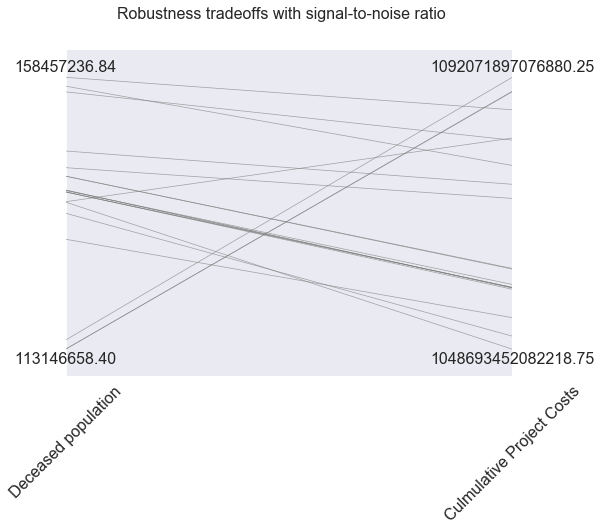

In [24]:
title = "Robustness tradeoffs with signal-to-noise ratio"
plot_optimal(df_sign, oois, title)

In [30]:
df_sign['sum']=df_sign['Culmulative Project Costs']+df_sign['Deceased population']
df_sign

,Culmulative Project Costs,Deceased population,sum
0,1.076294e+15,1.265978e+08,1.076294e+15
1,1.076295e+15,1.264948e+08,1.076295e+15
2,1.074015e+15,1.239247e+08,1.074015e+15
3,1.089750e+15,1.479834e+08,1.089751e+15
4,1.073771e+15,1.234460e+08,1.073771e+15
5,1.092072e+15,1.530498e+08,1.092072e+15
6,1.073772e+15,1.234410e+08,1.073772e+15
7,1.090658e+15,1.437686e+08,1.090658e+15
8,1.048693e+15,1.561255e+08,1.048694e+15
9,1.072217e+15,1.483295e+08,1.072217e+15


In [31]:
df_sign['sum'].min()

1048693608207744.6